# Νευρωνικά Δίκτυα 2021-2022
## 1η Εργαστηριακή Άσκηση
## Στοιχεία Ομάδας:


*   Αριθμός 90
*   Σαραντινόπουλος Ευστάθιος Αλέξανδρος -- 031 16801
*   Κωστόπουλος Κωνσταντίνος -- 031 17043
*   Τσαούσης Κωνσταντίνος -- 031 17652

## Στοιχεία dataset: 

* ### Dataset link: http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope
* ### Περιγραφή dataset: 
  To dataset έχει γίνει generated από ενα Monte Carlo Program, το Corsica λεπτομέρειες για το οποίο μπορούμε να βρούμε παρακάτω.
  <details>described in: D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998)</details>
  Πρόκειται για ενα simulation αποτύπωσης σωματιδιων γάμμα υψηλής ενέργειας από ένα επίγειο τηλεσκόπιο Chernikov gamma. Το τηλεσκόπιο αποτυπώνει σωματίδια και τα χαρακτηριστικά τους και τα κατηγοριοποιεί σε δυο κλάσεις τις gamma και hadron.
* ### Original description: 
  
    <details>
      The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

  Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 
  </details>





## A) Εισαγωγή

### 1) Setup
Παρακάτω κάνουμε τα βασικά updates και στην συνέχεια τα imports μας.

In [ ]:
!pip install --upgrade pip #upgrade pip package installer
!pip install scikit-learn --upgrade #upgrade scikit-learn package
!pip install numpy --upgrade #upgrade numpy package
!pip install pandas --upgrade #--upgrade #upgrade pandas package

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
import seaborn as sns

### 2) Data proccessing
Αφού έχουμε κάνει τα διαδικαστικά του setup προχωράμε στο data proccessing. Θα διαβάσουμε το dataset μας και θα το βάλουμε στην μεταβλητή data με το κατάλληλο format.

Στην συνέχεια θα ελέγξουμε τα χαρακτηριστικά, τις ετικέτες κοκ

In [ ]:
df = pd.read_csv("magic04.data",header=None)
data = df.to_numpy()
print("The Dataset contains",data.shape[0],"samples,",data.shape[1]-1,"features and a label.")
print(data)

The Dataset contains 19020 samples, 10 features and a label.
[[28.7967 16.0021 2.6449 ... 40.092 81.8828 'g']
 [31.6036 11.7235 2.5185 ... 6.3609 205.261 'g']
 [162.05200000000002 136.031 4.0612 ... 76.96 256.788 'g']
 ...
 [75.4455 47.5305 3.4483 ... 30.2987 256.5166 'h']
 [120.5135 76.9018 3.9939 ... 84.6874 408.3166 'h']
 [187.1814 53.0014 3.2093 ... 52.731 272.3174 'h']]


Προκύπτει ότι το Dataset αποτελείται από 19020 δείγματα, καθένα εκ των οποίων έχει 10 χαρακτηριστικά συν την binary ετικέτα του. Στη συνέχεια θα εξετάσουμε το είδος των χαρακτηριστικών μέσω του δείγματος μιας και το dataset δεν έχει απουσιάζουσες τιμές.

In [ ]:
print("Data types of features:",set([type(feature) for feature in data[0]]))
print("Inspection of features:",data[0])

Data types of features: {<class 'str'>, <class 'float'>}
Inspection of features: [28.7967 16.0021 2.6449 0.3918 0.1982 27.7004 22.011 -8.2027 40.092
 81.8828 'g']


Παρατηρούμε πως όλα τα χαρακτηριστικά έχουν float τιμές και η μόνη μη διατεταγμένη μορφή είναι η τελευταία στήλη που υποδηλώνει το label και είναι str.

### 3) Data labeling

Σύμφωνα με το documentation, οι ετικέτες των δειγμάτων λαμβάνουν τις τιμές g (gamma) ή h (hadron) και βρίσκονται στην τελευταία κολόνα.

In [ ]:
labels = data[:,-1]
feats  = data[:,:-1]
print("Labels of the Dataset:",set(labels))

Labels of the Dataset: {'g', 'h'}


In [ ]:
print(labels)
print(feats)

['g' 'g' 'g' ... 'h' 'h' 'h']
[[28.7967 16.0021 2.6449 ... -8.2027 40.092 81.8828]
 [31.6036 11.7235 2.5185 ... -9.9574 6.3609 205.261]
 [162.052 136.031 4.0612 ... -45.216 76.96 256.788]
 ...
 [75.4455 47.5305 3.4483 ... -9.4662 30.2987 256.5166]
 [120.5135 76.9018 3.9939 ... -63.8389 84.6874 408.3166]
 [187.1814 53.0014 3.2093 ... 31.4755 52.731 272.3174]]


### 4) Missing Values

In [ ]:
cat magic04.data | grep "?" | wc -l

0


Παρατηρούμε, λοιπόν, ότι το dataset μας δεν έχει απουσιάζουσες τιμές. Η linux εντολή cat magic04.data τυπώνει τα περιεχόμενα του αρχείου magic04.data και με την εντολή grep "?" παίρνει
τις άγνωστες τιμές και με τη βοήθεια της wc -l επιστρέφει τις γραμμές στις οποίες βρίσκονται.

### 5) Balance Inspection

Αφού το dataset μας δεν έχει κενά στοιχεία και δεν χρειάζεται κάποια περαιτέρω επεξεργασία, προχωράμε με το να εξετάσουμε το balance του. Λόγω της binary φύσης των labels, μπορούμε να εκτιμήσουμε απευθείας πόσα στοιχεία ανήκουν σε κάθε κλάση μέσω της συνάρτησης sum(), άρα και να αποφανθούμε περί της ισορροπίας του Dataset, διαιρώντας με τον συνολικό αριθμό των δειγμάτων:

In [ ]:
np_labels = np.array(labels)
print(np_labels)
print(feats.shape)
#print(len(np_labels[np_labels=='g']),"samples are gamma and",len(np_labels)-len(np_labels[np_labels=='g']),"are hadron")
print(len(np_labels[np_labels=='g']),"samples are gamma and",len(np_labels[np_labels=='h']),"are hadron")
print("The balance of the Dataset is",round(len(np_labels[np_labels=='g'])/len(labels),2),"in favor of the gamma samples.")

['g' 'g' 'g' ... 'h' 'h' 'h']
(19020, 10)
12332 samples are gamma and 6688 are hadron
The balance of the Dataset is 0.65 in favor of the gamma samples.


Είναι εμφανές πως τα δεδομένα κλίνουν κατά ένα βαθμό στην κλάση gamma, συνεπώς τα δεδομένα μας δεν είναι καλώς ισορροπημένα. Παρότι το ποσοστό παραμένει οριακά μικρότερο από 2/3 και θα μπορούσαμε να μην κάνουμε κάτι επιπλέον, επιλέγουμε να εφαρμόσουμε oversampling, θεωρώντας ότι όσο πιο ισορροπημένο είναι το dataset, τόσο καλύτερα θα είναι τα αποτελέσματα. Για να γίνει αυτό θα προηγηθεί το split.

### 6) Singular Values

Ελέγχουμε με το παρακάτω κομμάτι κώδικα αν υπάρχουν στήλες των οποίων οι τιμές είναι μοναδικές, ώστε να τις κάνουμε drop, προκειμένου να μην επηρεάσουν λανθασμένα το μοντέλο μας. Παρατηρούμε ότι δεν υπάρχουν στήλες με τέτοιες τιμές.

In [ ]:
for column in df.columns:
  if len(df[column].unique())==1:
    print(f'column {column} has a singular value. You should drop it')

## Β) Προετοιμασία

### 7) Train & Test split

Σαν τελευταίο βήμα επεξεργασίας, θα χωρίσουμε τα δεδομένα σε train και test μέσω της αντίστοιχης συνάρτησης *train_test_split()* της Scikit-learn. Αντίστοιχα χωρίζουμε και τα labels. Επιλέγουμε σχήμα 30% για το test set:

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(feats,labels,test_size=0.3,random_state=0) 

Ως τελευταίο βήμα, θα εφαρμόσουμε oversampling ούτως ώστε να εξισορροπήσουμε το dataset, όπως προείπαμε. Η έννοια του oversampling ειναι πρακτικά η επανάληψη samples από την υπολείπουσα κλάση, ώστε ο λόγος τους να τείνει προς το ιδανικό 50%. Θα εφαρμόσουμε για αυτό το σκοπό την συνάρτηση της Scikit-learn:

In [ ]:
ros = RandomOverSampler(random_state = 0)
x_train, y_train = ros.fit_resample(x_train,y_train)
balance = len(y_train[y_train=='g'])/len(y_train)

print("The balance of the train set is",balance)

The balance of the train set is 0.5


Παρατηρούμε την απευθείας βελτίωση στο λόγο των 2 κλάσεων. Σημειώνουμε πως επιλέγουμε να ισορροπήσουμε μόνο τα δεδομένα εκπαίδευσης, τα οποία είναι και τα μόνα που οφείλουν να είναι ισορροπημένα. Γενικώς αποφεύγουμε οποιαδήποτε περαιτέρω επεξεργασία στα test δεδομένα.

## C) Ταξινόμηση

### 8) Classification & Metrics

Οι ταξινομητές που θα μελετήσουμε είναι οι:

* Dummy
* Gaussian Naive Bayes (GNB)
* KNearestNeighbors (kNN)
* Logistic Regression (LR)



Ορίζουμε αρχικά μία συνάρτηση που εκπαιδεύει τους dummy classifiers με default τιμές και επιστρέφει σε dictionary τα predictions κάθε ταξινομητή, την ακρίβεια του καθώς και τους χρόνους fit και train 

In [ ]:
def DummyClassification(x_train,y_train,x_test,y_test):
    
    scores, predictions, fit_times, pred_times = {}, {}, {}, {}

    ### Initialization ###
    
    dc_uniform  = DummyClassifier(strategy="uniform")
    dc_const_gamma = DummyClassifier(strategy="constant",constant='g')
    dc_const_hadron = DummyClassifier(strategy="constant",constant='h')
    dc_stratified = DummyClassifier(strategy="stratified")
    dc_frequent = DummyClassifier(strategy="most_frequent")

    ### Fit ###
    
    start_time = time.time()
    dc_uniform.fit(x_train, y_train)
    fit_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_gamma.fit(x_train, y_train)
    fit_times['const_gamma'] = time.time()-start_time
    
    start_time = time.time()
    dc_const_hadron.fit(x_train, y_train)
    fit_times['const_hadron'] = time.time()-start_time
    
    start_time = time.time()
    dc_stratified.fit(x_train, y_train)
    fit_times['stratified'] = time.time()-start_time
    
    start_time = time.time()
    dc_frequent.fit(x_train,y_train)
    fit_times['frequent'] = time.time()-start_time
    
    ### Predict ###
    
    start_time = time.time()
    predictions['uniform']  = dc_uniform.predict(x_test)
    pred_times['uniform'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_gamma']  = dc_const_gamma.predict(x_test)
    pred_times['const_gamma'] = time.time()-start_time
    
    start_time = time.time()
    predictions['const_hadron']  = dc_const_hadron.predict(x_test)
    pred_times['const_hadron'] = time.time()-start_time
    
    start_time = time.time()
    predictions['stratified']  = dc_stratified.predict(x_test)
    pred_times['stratified'] = time.time()-start_time
    
    start_time = time.time()
    predictions['frequent'] = dc_frequent.predict(x_test)
    pred_times['frequent'] = time.time()-start_time

    ### Score ###
    
    scores['uniform']  = dc_uniform.score(x_test, y_test)
    scores['const_gamma']  = dc_const_gamma.score(x_test, y_test)
    scores['const_hadron']  = dc_const_hadron.score(x_test, y_test)
    scores['stratified']  = dc_stratified.score(x_test, y_test)
    scores['frequent'] = dc_frequent.score(x_test,y_test)
    
    return predictions, scores, fit_times, pred_times

### **Out of the Box**

Τρέχουμε όλους τους ταξινομητές χωρίς καμία βελτιστοποίηση.

#### ***Dummy***

In [ ]:
predictions, accuracies, _, _ = DummyClassification(x_train, y_train, x_test, y_test)

print("Confusion Matrices of the Dummy Classifier: \n")
for strategy in predictions:
  print(f'For strategy -> {strategy}:\n {confusion_matrix(y_test, predictions[strategy])}')

print("\nF1 Score of the Dummy Classifier: \n")
for strategy in predictions:
  print(f'For strategy -> {strategy}:')
  print(f'\tMicro: {f1_score(y_test, predictions[strategy], average = "micro")}')
  print(f'\tMacro: {f1_score(y_test, predictions[strategy], average = "macro")}\n')

print("\nAccuracy of the Dummy Classifier: \n")
for strategy in accuracies:
  print(f'For strategy -> {strategy}: {accuracies[strategy]}')

Confusion Matrices of the Dummy Classifier: 

For strategy -> uniform:
 [[1821 1868]
 [1046  971]]
For strategy -> const_gamma:
 [[3689    0]
 [2017    0]]
For strategy -> const_hadron:
 [[   0 3689]
 [   0 2017]]
For strategy -> stratified:
 [[1842 1847]
 [ 957 1060]]
For strategy -> frequent:
 [[3689    0]
 [2017    0]]

F1 Score of the Dummy Classifier: 

For strategy -> uniform:
	Micro: 0.48930949877322116
	Macro: 0.47771964361280284

For strategy -> const_gamma:
	Micro: 0.6465124430424115
	Macro: 0.3926556679084619

For strategy -> const_hadron:
	Micro: 0.3534875569575885
	Macro: 0.2611679399197203

For strategy -> stratified:
	Micro: 0.5085874518051174
	Macro: 0.4991808910983322

For strategy -> frequent:
	Micro: 0.6465124430424115
	Macro: 0.3926556679084619


Accuracy of the Dummy Classifier: 

For strategy -> uniform: 0.4919383105502979
For strategy -> const_gamma: 0.6465124430424115
For strategy -> const_hadron: 0.3534875569575885
For strategy -> stratified: 0.5
For strategy -

#### ***GaussianNB***

In [ ]:
bayes = GaussianNB()
bayes.fit(x_train, y_train)
predictions['bayes'] = bayes.predict(x_test)
accuracies['bayes'] = bayes.score(x_test, y_test)

print(f'Confusion Matrices of the Gaussian Naive Bayes Classifier:\n {confusion_matrix(y_test, predictions["bayes"])}')

print("\nF1 Score of the Gaussian Naive Bayes Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["bayes"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["bayes"], average = "macro")}\n')

print("\nAccuracy of the Gaussian Naive Bayes Classifier: \n")
print(f'{accuracies["bayes"]}')

Confusion Matrices of the Gaussian Naive Bayes Classifier:
 [[3317  372]
 [1214  803]]

F1 Score of the Gaussian Naive Bayes Classifier: 

	Micro: 0.7220469681037505
	Macro: 0.6550943965753802


Accuracy of the Gaussian Naive Bayes Classifier: 

0.7220469681037505


#### ***kNN***

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)
predictions['knn'] = knn.predict(x_test)
accuracies['knn'] = knn.score(x_test, y_test)

print(f'Confusion Matrices of the kNN Classifier:\n {confusion_matrix(y_test, predictions["knn"])}')

print("\nF1 Score of the kNN Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["knn"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["knn"], average = "macro")}\n')

print("\nAccuracy of the kNN Classifier: \n")
print(f'{accuracies["knn"]}')

Confusion Matrices of the kNN Classifier:
 [[3189  500]
 [ 765 1252]]

F1 Score of the kNN Classifier: 

	Micro: 0.778303540133193
	Macro: 0.7494281405630201


Accuracy of the kNN Classifier: 

0.7783035401331931


In [ ]:
knn_validate = cross_validate(knn, x_train, y = y_train, cv = 10, return_train_score = True, scoring = ['accuracy'])
print("average:", np.mean(np.array(knn_validate["test_accuracy"])))

average: 0.8840195440524388


#### ***Logistic Regression***

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions['lr'] = lr.predict(x_test)
accuracies['lr'] = lr.score(x_test, y_test)

print(f'Confusion Matrices of the Logistic Regression Classifier:\n {confusion_matrix(y_test, predictions["lr"])}')

print("\nF1 Score of the Logistic Regression Classifier: \n")
print(f'\tMicro: {f1_score(y_test, predictions["lr"], average = "micro")}')
print(f'\tMacro: {f1_score(y_test, predictions["lr"], average = "macro")}\n')

print("\nAccuracy of the Logistic Regression Classifier: \n")
print(f'{accuracies["lr"]}')

Confusion Matrices of the Logistic Regression Classifier:
 [[2995  694]
 [ 562 1455]]

F1 Score of the Logistic Regression Classifier: 

	Micro: 0.7798808271994392
	Macro: 0.7625873741785989


Accuracy of the Logistic Regression Classifier: 

0.7798808271994392


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
lr_validate = cross_validate(lr, x_train, y = y_train, cv = 10, return_train_score = True, scoring = ['accuracy'])
print("average:", np.mean(np.array(lr_validate["test_accuracy"])))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


average: 0.7584758504166399


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### *Bar Plots*

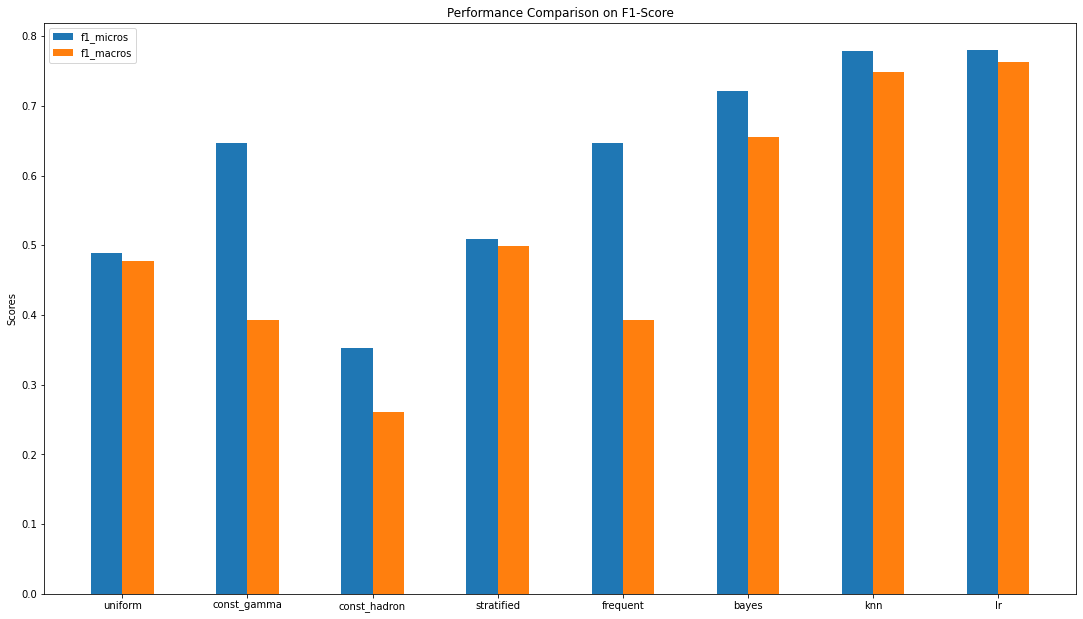

In [ ]:
f1_macros, f1_micros, labels = [],[],[]
for clf in predictions:  
    f1_micros.append(f1_score(y_test,predictions[clf],average='micro'))
    f1_macros.append(f1_score(y_test,predictions[clf],average='macro'))
    labels.append(clf)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/2, f1_macros, width, label='f1_macros')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

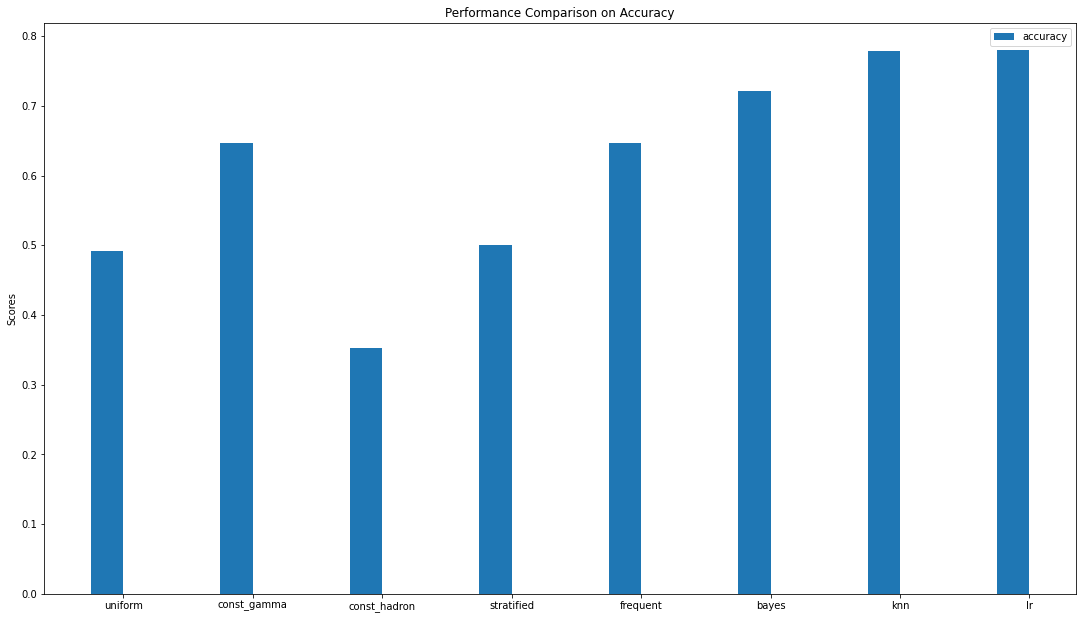

In [ ]:
scores, acc_labels = [],[]
for clf in accuracies:  
    scores.append(accuracies[clf])
    acc_labels.append(clf)

x = np.arange(len(acc_labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scores, width, label='accuracy')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(acc_labels)
ax.legend()

plt.show()

#### *Discussion*

* Μεταξύ των dummy ταξινομητών, η καλύτερη στρατηγική είναι να διαλέγουμε πάντοτε την πιο συχνή κλάση (frequent) ή ισοδύναμα σταθερά την κλάση που είναι η πιο συχνή (constant-0), μιας και το test set δεν είναι ισορροπημένο, όπως φαίνεται παραπάνω.
* Εαν δοκιμάσουμε πολλά runs, θα παρατηρήσουμε ότι η επιλογή stratified, δηλαδή να επιλέγουμε τυχαία κλάση διατηρώντας την κατανομή των κλάσεων στο training set, ενώ στη γενική περίπτωση δίνει καλύτερα αποτελέσματα από τη random επιλογή, στη προκειμένη, λόγω της ισορροπίας του train dataset, οι δύο μέθοδοι είναι ισοδύναμες. 
* Ο k-NN ταξινομητής δίνει καλύτερο αποτέλεσμα από τους dummy classifiers, αφού βασίζεται σε έναν αλγόριθμο λογικής ανάλυσης των δεδομένων. Επιπλέον λόγω του εκτενούς μεγέθους του test dataset, το αποτέλεσμα του ταξινομητή είναι ικανοποιητικό.
* Ο Naive Bayes εμφανίζει επίσης βελτιωμένα αποτελέσματα συγκριτικά με τους dummy ταξινομητές, αλλά όχι καλύτερα από τον kNN. Αυτό οφείλεται στις "αφελείς" παραδοχές του συγκεκριμένου ταξινομήτη, όπως το ότι υποθέτει κανονική κατανομή των features και ανεξαρτησία μεταξύ τους.
* Τέλος, ο Logistic Regression εμφανίζει τη δεύτερη καλύτερη επίδοση μετά τον kNN. 

### 9) **Optimization**

Δεν έχει νόημα να κάνουμε βελτιστοποίηση στους NGB και στους Dummy Classifiers, αφού δεν επηρεάζονται καθόλου από το pre-processing που θα ακολουθήσουμε. Αυτό συμβαίνει, καθώς δεν έχουν παραμέτρους προς βελτιστοποίηση.

#### *Pre-Processing*

Αρχικοποιούμε τους εκτιμητές:

In [ ]:
selector = VarianceThreshold()
minmax = MinMaxScaler()
pca = PCA()

Η διαδικασία εύρεσης των βέλτιστων υπερπαραμέτρων είναι εξαιρετικά χρονοβόρα και επαναληπτική διαδικασία πειραματισμών. Για αυτό το λόγο θα εκμεταλλευτούμε το μεγάλο μέγεθος του dataset και θα χρησιμοποιήσουμε μόνο ένα υποσύνολο των διαθέσιμων δειγμάτων:

In [ ]:
x_train_copy = x_train
y_train_copy = y_train
x_test_copy  = x_test
y_test_copy  = y_test

x_train_sample, y_train_sample = shuffle(x_train, y_train, random_state=3)
x_train_sample = x_train_sample[0:2000,:]
y_train_sample = y_train_sample[0:2000]

Μπορούμε τώρα να προχωρήσουμε στην εύρεση των βέλτιστων παραμέτρων των μοντέλων μας. Θα εξετάσουμε χωριστά τις παραμέτρους των ταξινομητών kΝΝ και Logistic Regression. Επίσης, επιλέγουμε να μην κάνουμε feature selection καθώς ο αριθμός των features είναι ήδη αρκετά μικρός σε σύγκριση με την ποσότητα των δεδομένων.

In [ ]:
fit_times, pred_times, new_predictions, new_accuracies = {}, {}, {}, {}

In [ ]:
for strategy in predictions:
  new_predictions[strategy] = predictions[strategy]
for strategy in accuracies:
  new_accuracies[strategy] = accuracies[strategy]

#### ***kNN***

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)

n_components = np.arange(1,11)
k = np.arange(1,50,5)
knn_weights = ['uniform','distance']
knn_metrics = ['euclidean','manhattan','chebyshev']

##### *kNN Pipelines*

In [ ]:
pipe = Pipeline(steps=[('scaler', minmax),('selector', selector),('pca', pca),('kNN', knn)])
knn_estimator = GridSearchCV(pipe, dict(pca__n_components = n_components,
                                        kNN__n_neighbors = k,
                                        kNN__weights = knn_weights,
                                        kNN__metric = knn_metrics), cv=10, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
knn_estimator.fit(x_train_sample, y_train_sample)
knn_estimator.predict(x_test)
print("Overall fit and predict time: %s seconds" % (time.time()-start_time))
print("Best parameters",knn_estimator.best_params_)                            

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Overall fit and predict time: 367.9833629131317 seconds
Best parameters {'kNN__metric': 'manhattan', 'kNN__n_neighbors': 6, 'kNN__weights': 'distance', 'pca__n_components': 10}


Έχοντας εξάγει παραμέτρους για ένα μικρό δείγμα του train set, επαναλαμβάνουμε την διαδικασία για όλο το dataset με πολύ μικρότερο εύρος παραμέτρων, ώστε να έχουμε μεγάλη ακρίβεια.

In [ ]:
n_components = np.arange(9,11)
k = np.arange(3,9)
knn_weights = ['distance']
knn_metrics = ['manhattan']

In [ ]:
pipe = Pipeline(steps=[('scaler', minmax),('selector', selector),('pca', pca),('kNN', knn)])
knn_estimator = GridSearchCV(pipe, dict(pca__n_components = n_components,
                                        kNN__n_neighbors = k,
                                        kNN__weights = knn_weights,
                                        kNN__metric = knn_metrics), cv=10, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
knn_estimator.fit(x_train, y_train)
knn_estimator.predict(x_test)
print("Overall fit and predict time: %s seconds" % (time.time()-start_time))
print("Best parameters",knn_estimator.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Overall fit and predict time: 23.11628746986389 seconds
Best parameters {'kNN__metric': 'manhattan', 'kNN__n_neighbors': 8, 'kNN__weights': 'distance', 'pca__n_components': 10}


Έχοντας τώρα τις βέλτιστες παραμέτρους, εκπαιδεύουμε το train set με kNN ταξινομητή.

In [ ]:
x_train_copy = minmax.fit_transform(x_train)
x_test_copy = minmax.fit_transform(x_test)

pca_complete = PCA(knn_estimator.best_params_['pca__n_components'])

x_train_copy = pca_complete.fit_transform(x_train_copy)
x_test_copy = pca_complete.fit_transform(x_test_copy)

knn = KNeighborsClassifier(n_neighbors=knn_estimator.best_params_['kNN__n_neighbors'],
                           weights=knn_estimator.best_params_['kNN__weights'],
                           metric=knn_estimator.best_params_['kNN__metric'])

start_time = time.time()
knn.fit(x_train_copy,y_train_copy)
fit_times['knn'] = time.time() - start_time

start_time = time.time()
new_predictions['knn'] = knn.predict(x_test_copy)
pred_times['knn'] = time.time() - start_time

new_accuracies['knn'] = knn.score(x_test_copy,y_test)


print(f'Confusion Matrices of the kNN Classifier:\n {confusion_matrix(y_test, new_predictions["knn"])}')

print("\nAccuracy of the kNN Classifier:")
print(f'{new_accuracies["knn"]}')

print("\nClassification Report of k-NN:\n", classification_report(y_test,new_predictions['knn']))

Confusion Matrices of the kNN Classifier:
 [[3021  668]
 [ 484 1533]]

Accuracy of the kNN Classifier:
0.7981072555205048

Classification Report of k-NN:
               precision    recall  f1-score   support

           g       0.86      0.82      0.84      3689
           h       0.70      0.76      0.73      2017

    accuracy                           0.80      5706
   macro avg       0.78      0.79      0.78      5706
weighted avg       0.80      0.80      0.80      5706



#### ***Logistic Regression***

In [ ]:
lr = LogisticRegression()

params = [{'lr__penalty': ['l1'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['liblinear', 'saga'], 'pca__n_components' : np.arange(1,11)},
          {'lr__penalty': ['l2'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['sag', 'liblinear', 'newton-cg', 'lbfgs', 'saga'], 'pca__n_components' : np.arange(1,11)}, 
          {'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['liblinear', 'saga'], 'pca__n_components' : np.arange(1,11)},
          {'lr__penalty': ['l1','l2', 'elasticnet', 'none'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__l1_ratio': [0, 0.5, 1], 'lr__solver': ['saga'], 'pca__n_components' : np.arange(1,11)},
          {'lr__penalty': ['l2', 'none'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['sag', 'newton-cg', 'lbfgs', 'saga'], 'pca__n_components' : np.arange(1,11)},
          {'lr__penalty': ['l1', 'none'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['saga'], 'pca__n_components' : np.arange(1,11)},
          {'lr__penalty': ['none'], 'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__solver': ['sag', 'newton-cg', 'lbfgs', 'saga'], 'pca__n_components' : np.arange(1,11)}] 

##### *LR Pipelines*

In [ ]:
pipe = Pipeline(steps=[('scaler', minmax),('selector', selector),('pca', pca),('lr', lr)])
lr_estimator = GridSearchCV(pipe, params, cv=10, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
lr_estimator.fit(x_train_sample, y_train_sample)
lr_estimator.predict(x_test)
print("Overall fit and predict time: %s seconds" % (time.time()-start_time))
print("Best parameters",lr_estimator.best_params_) 

Fitting 10 folds for each of 1850 candidates, totalling 18500 fits
Overall fit and predict time: 277.79481768608093 seconds
Best parameters {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'pca__n_components': 9}


Και τα optimal:

In [ ]:
params = [{'lr__penalty': ['l1'], 'lr__C': [0.1, 1, 10], 'lr__solver': ['saga'], 'pca__n_components' : np.arange(8,11)}] 

In [ ]:
pipe = Pipeline(steps=[('scaler', minmax),('selector', selector),('pca', pca),('lr', lr)])
lr_estimator = GridSearchCV(pipe, params, cv=10, scoring='f1_macro', n_jobs=-1,verbose=1)

start_time = time.time()
lr_estimator.fit(x_train, y_train)
lr_estimator.predict(x_test)
print("Overall fit and predict time: %s seconds" % (time.time()-start_time))
print("Best parameters",lr_estimator.best_params_) 

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Overall fit and predict time: 12.16222095489502 seconds
Best parameters {'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'saga', 'pca__n_components': 10}


Training:

In [ ]:
x_train_copy = minmax.fit_transform(x_train)
x_test_copy = minmax.fit_transform(x_test)

pca_complete = PCA(lr_estimator.best_params_['pca__n_components'])

x_train_copy = pca_complete.fit_transform(x_train_copy)
x_test_copy = pca_complete.fit_transform(x_test_copy)

logreg = LogisticRegression(C=lr_estimator.best_params_['lr__C'],
                        penalty=lr_estimator.best_params_['lr__penalty'],
                        solver=lr_estimator.best_params_['lr__solver'],
                        max_iter=500, tol=1e5)

start_time = time.time()
logreg.fit(x_train_copy,y_train_copy)
fit_times['lr'] = time.time() - start_time

start_time = time.time()
new_predictions['lr'] = logreg.predict(x_test_copy)
pred_times['lr'] = time.time() - start_time

new_accuracies['lr'] = logreg.score(x_test_copy,y_test)


print(f'Confusion Matrices of the lr Classifier:\n {confusion_matrix(y_test, new_predictions["lr"])}')

print("\nAccuracy of the lr Classifier:")
print(f'{new_accuracies["lr"]}')

print("\nClassification Report of lr:\n", classification_report(y_test,new_predictions['lr']))

Confusion Matrices of the lr Classifier:
 [[2982  707]
 [ 544 1473]]

Accuracy of the lr Classifier:
0.7807570977917981

Classification Report of lr:
               precision    recall  f1-score   support

           g       0.85      0.81      0.83      3689
           h       0.68      0.73      0.70      2017

    accuracy                           0.78      5706
   macro avg       0.76      0.77      0.76      5706
weighted avg       0.79      0.78      0.78      5706



### 10) **Results**

Markdown πίνακας. Περιέχει τις προηγούμενες (out of the box) τιμές των knn, lr και στα delta φαίνονται οι καινούργιες τους.

| Classifier | F1 Score (Micro) | F1 Score (Macro) | Accuracy | Delta_F1 Score (Macro) | Delta_Accuracy | Train_Time | Test_Time |
|:----:|:------:|:-------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| **dc_uniform**       |         0.4893 |     0.4777     |0.4919|0.0|0.0|-|-|
| **dc_const_gamma**     |      0.6465 |    0.3926    |0.6465|0.0|0.0|-|-|
| **dc_const_hadron**       |        0.3534 |     0.2611     |0.3534|0.0|0.0|-|-|
| **dc_stratified**         |          0.5085 |      0.4991      |0.5|0.0|0.0|-|-|
| **dc_frequent**       |       0.6465 |    0.3926    |0.6465|0.0|0.0|-|-|
| **gnb**    |     0.7220 |    0.6550   |0.7220|0.0|0.0|-|-|
| **knn**    |     0.7783 |    0.7494   |0.7783|0.78 - 0.7494 = **0.0326**|0.7981 - 0.7783 = **0.0198**|0.06428360939025879|0.5424604415893555|
| **lr**    |     0.7798 |    0.7625   |0.7798|0.78 - 0.7625 = **0.0175**|0.7807 - 0.7798 = **0.0009**|0.06702542304992676|0.004578590393066406|

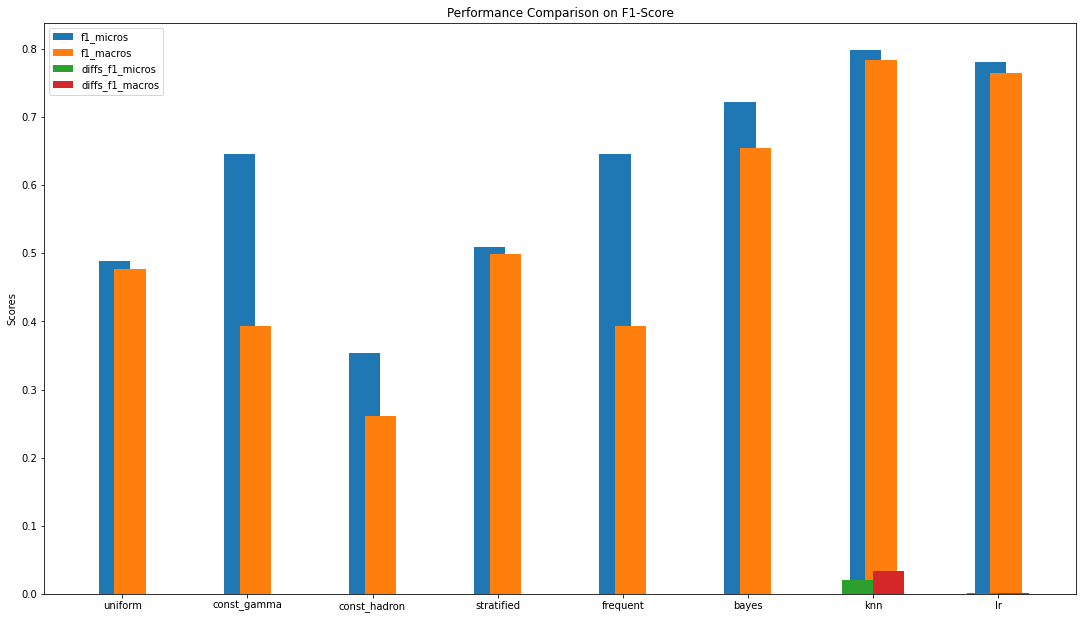

In [ ]:
new_f1_macros, new_f1_micros, new_labels = [],[],[]
for clf in new_predictions:  
    new_f1_micros.append(f1_score(y_test,new_predictions[clf],average='micro'))
    new_f1_macros.append(f1_score(y_test,new_predictions[clf],average='macro'))
    new_labels.append(clf)

x = np.arange(len(new_labels))
width = 0.25

diffs_macros, diffs_micros = [], []
for i in range(len(new_f1_micros)):
  diffs_micros.append(new_f1_micros[i] - f1_micros[i])
  diffs_macros.append(new_f1_macros[i] - f1_macros[i])

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/4, new_f1_micros, width, label='f1_micros')
rects2 = ax.bar(x + width/4, new_f1_macros, width, label='f1_macros')
rects3 = ax.bar(x - width/2, diffs_micros, width, label='diffs_f1_micros')
rects4 = ax.bar(x + width/2, diffs_macros, width, label='diffs_f1_macros')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(new_labels)
ax.legend()

plt.show()

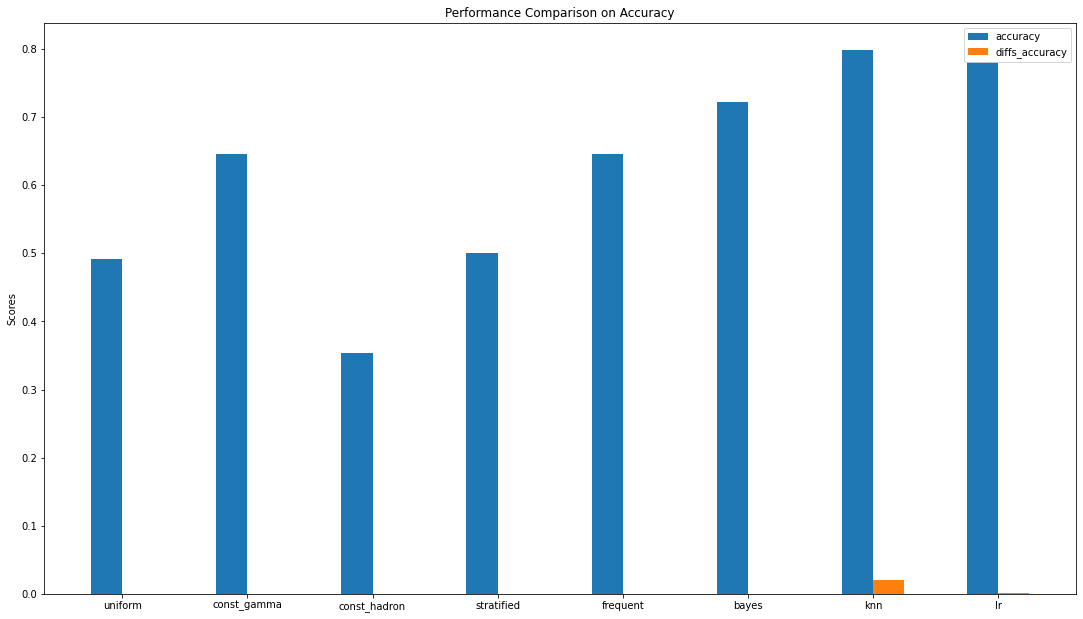

In [ ]:
new_scores, new_acc_labels = [],[]
for clf in accuracies:  
    new_scores.append(new_accuracies[clf])
    new_acc_labels.append(clf)

x = np.arange(len(new_acc_labels))
width = 0.25

diffs_accuracies = []
for i in range(len(new_scores)):
  diffs_accuracies.append(new_scores[i] - scores[i])

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, new_scores, width, label='accuracy')
rects2 = ax.bar(x + width/2, diffs_accuracies, width, label='diffs_accuracy')

fig.set_size_inches(18.5, 10.5)
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison on Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(new_acc_labels)
ax.legend()

plt.show()

Ο καλύτερος ταξινομητής είναι αναμφίβολα ο kNN και ο χειρότερος ο GNB. Προφανώς αυτό ήταν αναμενόμενο. Η αφελής φύση του GNB τον καθιστά ανήμπορο να επιλύσει αποδοτικά τα περισσότερα προβλήματα (τουλάχιστον μόνος του), ενώ ο kNN, πέρα από την γενικά καλή του επίδοση, είναι ιδανικός για το πρόβλημα αυτό. Αφού τα δεδομένα μας είναι δυαδικά (g/h), ο kNN θα λειτουργήσει σαν μια ευθεία που θα τα διαχωρίσει και, έχοντας αρκετούς γείτονες k, θα βελτιστοποιήσει τη λύση του προβλήματος.
<br>Να σημειωθεί εδώ ότι ο Linear Regression αύξησε ανεπαίσθητα την επίδοσή του παρά τη χρήση βέλτιστων παραμέτρων. Αυτό συμβαίνει καθώς η φύση του ταξινομητή αυτή είναι ιδιαίτερα ασταθής και δουλεύει ήδη εξαιρετικά για το συγκεκριμένο dataset. Επιπλέον, φαίνεται ότι οι by default παράμετροι του Linear Regression είναι οριακά optimal.

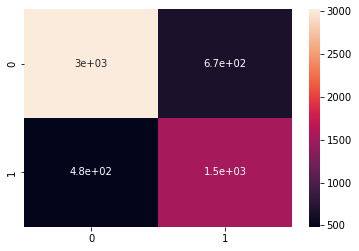

In [ ]:
sns.heatmap(confusion_matrix(y_test, new_predictions["knn"]), annot=True)

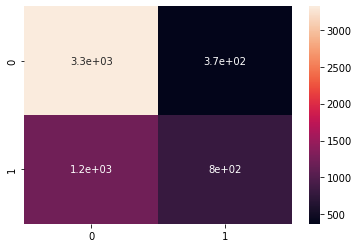

In [ ]:
sns.heatmap(confusion_matrix(y_test, new_predictions["bayes"]), annot=True)

Συμπερασματικά, επιλέγουμε τον kNN ταξινομητή, τόσο λόγω του υψηλότερου accuracy του, όσο και του f1 score του. Ωστόσο, ίσως ο Logistic Regression να αποτελούσε κι αυτός καλή επιλογή, αφού ο kNN έχει τεράστια πολυπλοκότητα και στην πράξη ίσως να μην είναι τόσο εύχρηστος.